In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, regexp_tokenize
import os
import joblib
import numpy as np
import spacy
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec

In [2]:
print("Tentar baixar 'punkt_tab'...")
nltk.download('punkt_tab')
print("Tentar baixar 'stopwords'...")
nltk.download('stopwords')

Tentar baixar 'punkt_tab'...
Tentar baixar 'stopwords'...


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Download do NLTK (só na primeira vez)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Configurações gerais
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. CARREGAR E ENTENDER OS DADOS

In [5]:
print("Carregar dataset completo em partes...")
chunksize = 100000  # Processar em lotes de 100.000 linhas
data_chunks = []
for chunk in pd.read_csv('complaints.csv', chunksize=chunksize):
    chunk = chunk.dropna()
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)

print("Primeiras 5 linhas do dataset:")
print(data.head())
print("\nInformações do dataset:")
print(data.info())

Carregar dataset completo em partes...


Primeiras 5 linhas do dataset:
   Unnamed: 0         product_5  \
0         234  Credit Reporting   
1         240   Debt Collection   
2         257  Credit Reporting   
3         271  Credit Reporting   
4         279  Credit Reporting   

                                           narrative  \
0  Dear Possible Financial Inc you guyss aree rep...   
1  XXXX XXXX XXXX ( debt collector ), sent my boy...   
2  I been receiving alerts my information was fou...   
3  Subject : Dispute of Inaccurate Information on...   
4  Do you believe your company owns the promissor...   

                                             Product Date received  \
0  Credit reporting or other personal consumer re...    2024-07-27   
1                                    Debt collection    2024-07-27   
2  Credit reporting or other personal consumer re...    2024-07-23   
3  Credit reporting or other personal consumer re...    2024-07-27   
4  Credit reporting or other personal consumer re...    2024-07-26   



In [6]:
# Características
print("- Origem: Consumer Financial Protection Bureau (CFPB), EUA.")
data["Date received"] = pd.to_datetime(data["Date received"])
print(f"- Periodo: de {data['Date received'].min()} a {data['Date received'].max()}")
print("- Gênero: Reclamações textuais de consumidores sobre serviços financeiros.")
print("- Língua: Inglês.")
print("- Anotação: Rótulos ('Product') atribuídos pelos consumidores ao submeter reclamações.")
print(f"- Total de reclamações: {len(data)}")
print(f"- Colunas disponíveis: {list(data.columns)}")
print(f"\nTotal de reclamações: {len(data)}")

- Origem: Consumer Financial Protection Bureau (CFPB), EUA.
- Periodo: de 2015-03-19 00:00:00 a 2024-07-31 00:00:00
- Gênero: Reclamações textuais de consumidores sobre serviços financeiros.
- Língua: Inglês.
- Anotação: Rótulos ('Product') atribuídos pelos consumidores ao submeter reclamações.
- Total de reclamações: 1757155
- Colunas disponíveis: ['Unnamed: 0', 'product_5', 'narrative', 'Product', 'Date received', 'Sub-product', 'Issue', 'Sub-issue', 'Company', 'State', 'Timely response?']

Total de reclamações: 1757155


## 1.1 Seleção Balanceada: 10.000 exemplos por classe (total 50.000)

In [7]:
n_samples_per_class = 10000
classes = data["product_5"].unique()
balanced_data = []

for class_name in classes:
    class_data = data[data["product_5"] == class_name]
    class_sample = class_data.sample(n=n_samples_per_class, random_state=42)
    balanced_data.append(class_sample)

In [8]:
# Concatenar os dados balanceados
data_balanced = pd.concat(balanced_data, ignore_index=True)
print("\nDistribuição das classes após seleção balanceada:")
print(data_balanced["product_5"].value_counts())
print(f"Total de exemplos: {len(data_balanced)}")


Distribuição das classes após seleção balanceada:
product_5
Credit Reporting              10000
Debt Collection               10000
Loans                         10000
Bank Accounts and Services    10000
Credit Card Services          10000
Name: count, dtype: int64
Total de exemplos: 50000


In [9]:
# Encontrar uma reclamação pequena nas 20 primeiras reclamações para guardar como exemplo
complaint_index = None
for complaint_index in range(50):
    example_complaint = data["narrative"].iloc[complaint_index]
    if len(example_complaint) < 150:
        print("Tamanho da reclamação:", len(example_complaint))
        print("Classe:", data["product_5"].iloc[complaint_index])
        print("\nReclamação para exemplos:\n", example_complaint)
        break

Tamanho da reclamação: 90
Classe: Credit Reporting

Reclamação para exemplos:
 I was reviewing my consumer report and noticed these inquiries that does not belong to me.


# 2. PRÉ-PROCESSAMENTO

In [10]:
ps = PorterStemmer()
nlp = spacy.load("en_core_web_sm")
sw = set(stopwords.words("english"))

In [11]:
# Definir os padrões de regex
REGEX_PATTERN = r'''(?x)           # Retirado do Notebook do Professor "preprocessing.ipynb"
    (?:[A-Z]\.)+         
    | \w+(?:-\w+)*       
    | \$?\d+(?:\.\d+)?%? 
    | \.\.\.             
    | [][.,;"'?():-_`]  
'''

In [12]:
# Funções de pré-processamento
def preprocess_stemming(text):
    tokens = regexp_tokenize(str(text).lower(), REGEX_PATTERN)
    tokens = [ps.stem(w) for w in tokens if w not in sw]
    return ' '.join(tokens)

def preprocess_lemmatization(text):
    tokens = regexp_tokenize(str(text).lower(), REGEX_PATTERN)
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc if token.text not in sw and token.is_alpha]
    return ' '.join(tokens)

In [13]:
# Dicionário com as configurações de pré-processamento de forma a verificar resultados
preprocessing_configs = {
    "stemming": (preprocess_stemming, "consumer_complaints_stem_50000.csv", "processed_text_stem"),
    "lemmatization": (preprocess_lemmatization, "consumer_complaints_lem_50000.csv", "processed_text_lem")
}

In [14]:
# Aplicar pré-processamento para cada configuração
for config_name, (preprocess_func, file_name, column_name) in preprocessing_configs.items():
    corpus = [preprocess_func(review) for review in data_balanced["narrative"]]
    data_balanced[column_name] = corpus
    data_balanced.to_csv(file_name, index=False)
    print(f"Corpus salvo como '{file_name}'.")

Corpus salvo como 'consumer_complaints_stem_50000.csv'.
Corpus salvo como 'consumer_complaints_lem_50000.csv'.


In [15]:
# Comparação de pré-processamento na primeira reclamação
comparison_data = {
    "Original": word_tokenize(example_complaint.lower()),
    "Stemming": preprocess_stemming(example_complaint).split(),
    "Lemmatization": preprocess_lemmatization(example_complaint).split()
}

In [16]:
# Ajustar comprimentos para o DataFrame
max_len = max(len(tokens) for tokens in comparison_data.values())
for key in comparison_data:
    comparison_data[key] += [''] * (max_len - len(comparison_data[key]))

comparison_df = pd.DataFrame(comparison_data)
print("\nComparação entre Stemming e Lemmatization:")
print(comparison_df)
comparison_df.to_csv("preprocessing_comparison.csv", index=False)
print("\nComparação salva em 'preprocessing_comparison.csv'")


Comparação entre Stemming e Lemmatization:
     Original Stemming Lemmatization
0           i   review        review
1         was   consum      consumer
2   reviewing   report        report
3          my    notic        notice
4    consumer  inquiri       inquiry
5      report   belong        belong
6         and        .              
7     noticed                       
8       these                       
9   inquiries                       
10       that                       
11       does                       
12        not                       
13     belong                       
14         to                       
15         me                       
16          .                       

Comparação salva em 'preprocessing_comparison.csv'


# 3. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

In [17]:
# Função para realizar EDA num corpus
def perform_eda(corpus, config_name):
    
    # a) Comprimento das reclamações
    word_counts = corpus.apply(lambda x: len(str(x).split()))  # Split simples, pois o corpus já está tokenizado
    print("\nEstatísticas do Comprimento das Reclamações:")
    print(word_counts.describe())
    
    # Histograma com ajuste do eixo X
    plt.figure()
    sns.histplot(word_counts, bins=50, kde=True)
    plt.title(f"Distribuição do Comprimento das Reclamações ({config_name})")
    plt.xlabel("Número de Palavras")
    plt.ylabel("Frequência")
    xlim_max = word_counts.quantile(0.99)
    plt.xlim(0, xlim_max)
    plt.tight_layout()
    plt.savefig(f"word_count_distribution_{config_name.lower().replace(' ', '_')}.png")
    plt.show()
    
    # b) Análise de vocabulário com CountVectorizer
    vectorizer = CountVectorizer(max_features=20, stop_words=list(sw))
    X = vectorizer.fit_transform(corpus).toarray()
    vocab = vectorizer.get_feature_names_out()
    print(f"\nTop 20 Palavras no Vocabulário ({config_name}):")
    print(vocab)
    custom_stopwords = sw
    
    # c) N-gramas mais frequentes
    bigram_counts = Counter()
    batch_size = 10000
    for i in range(0, len(corpus), batch_size):
        batch_corpus = corpus[i:i + batch_size].astype(str).tolist()
        for doc in batch_corpus:
            tokens = doc.split()  # Tokens já estão stemmed ou lematizados
            bigrams = ngrams(tokens, 2)
            bigram_counts.update(bigrams)
    
    bigram_counts = bigram_counts.most_common(10)
    print(f"\nTop 10 Bigramas Mais Frequentes ({config_name}):")
    for bigram, count in bigram_counts:
        print(f"{' '.join(bigram)}: {count}")
    
    plt.figure()
    bigram_labels = [" ".join(bigram[0]) for bigram in bigram_counts]
    bigram_values = [bigram[1] for bigram in bigram_counts]
    sns.barplot(x=bigram_labels, y=bigram_values)
    plt.title(f"Top 10 Bigramas Mais Frequentes ({config_name})")
    plt.xlabel("Bigrama")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"top_bigrams_{config_name.lower().replace(' ', '_')}.png")
    plt.show()
    
    return custom_stopwords


Estatísticas do Comprimento das Reclamações:
count    50000.000000
mean       125.965880
std        154.196178
min          1.000000
25%         43.000000
50%         85.000000
75%        154.000000
max       5474.000000
Name: processed_text_stem, dtype: float64


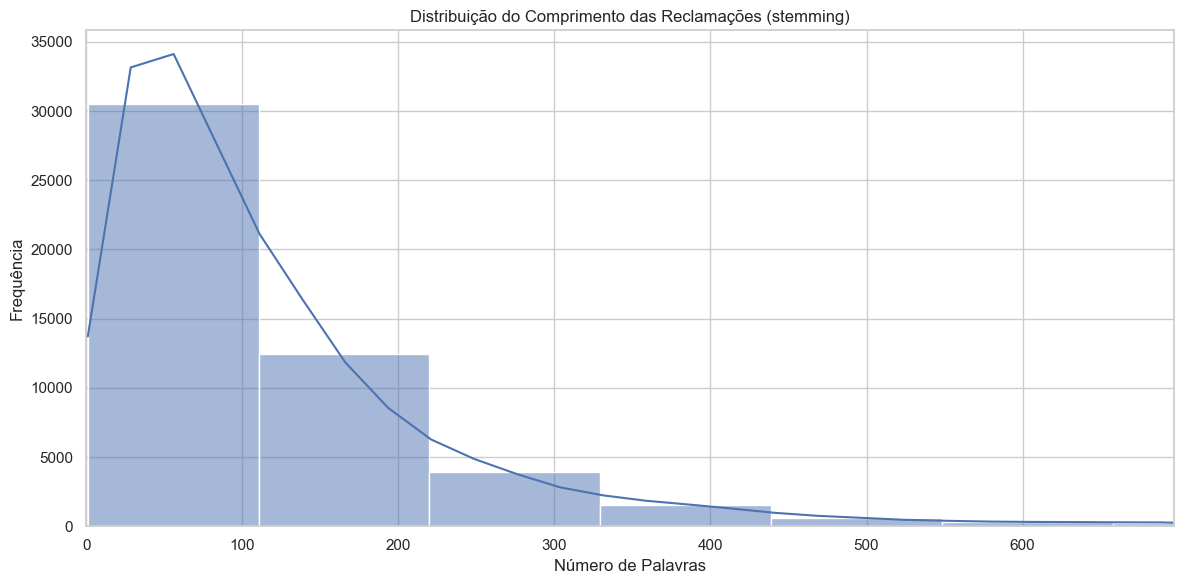


Top 20 Palavras no Vocabulário (stemming):
['00' 'account' 'bank' 'call' 'card' 'check' 'consum' 'credit' 'day'
 'debt' 'inform' 'loan' 'payment' 'receiv' 'report' 'time' 'told' 'would'
 'xx' 'xxxx']

Top 10 Bigramas Mais Frequentes (stemming):
xxxx xxxx: 245679
xx xx: 73016
xx xxxx: 51060
xxxx ,: 41519
xxxx .: 35393
credit report: 23172
, xxxx: 21633
. xxxx: 19749
account .: 15730
' ': 13556


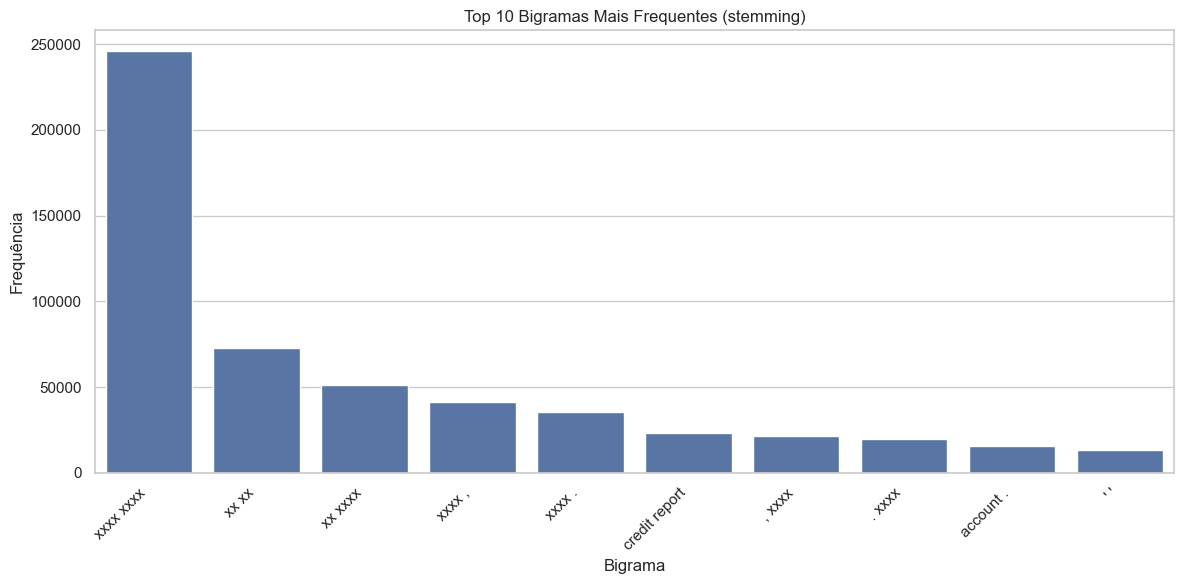


Estatísticas do Comprimento das Reclamações:
count    50000.000000
mean       102.375900
std        123.504302
min          1.000000
25%         35.000000
50%         69.000000
75%        126.000000
max       4505.000000
Name: processed_text_lem, dtype: float64


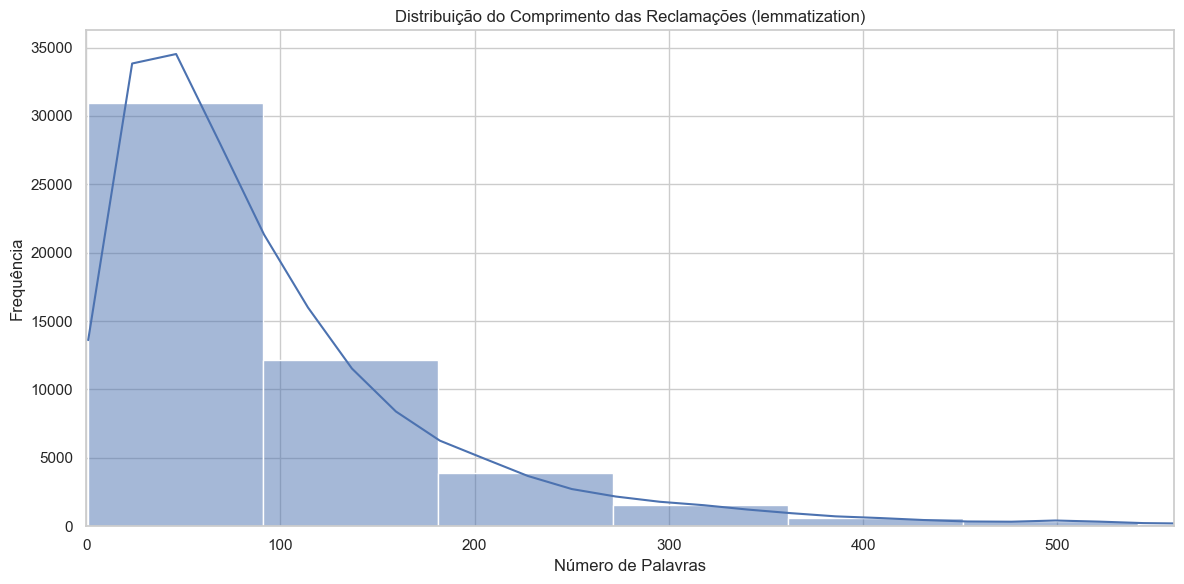


Top 20 Palavras no Vocabulário (lemmatization):
['account' 'bank' 'call' 'card' 'credit' 'get' 'information' 'loan' 'make'
 'pay' 'payment' 'receive' 'report' 'say' 'send' 'tell' 'time' 'would'
 'xx' 'xxxx']

Top 10 Bigramas Mais Frequentes (lemmatization):
xxxx xxxx: 269472
xx xx: 74046
xx xxxx: 53628
credit report: 17599
xxxx xx: 13772
credit card: 12540
xxxx account: 7686
reporting agency: 6224
account xxxx: 6139
wells fargo: 5984


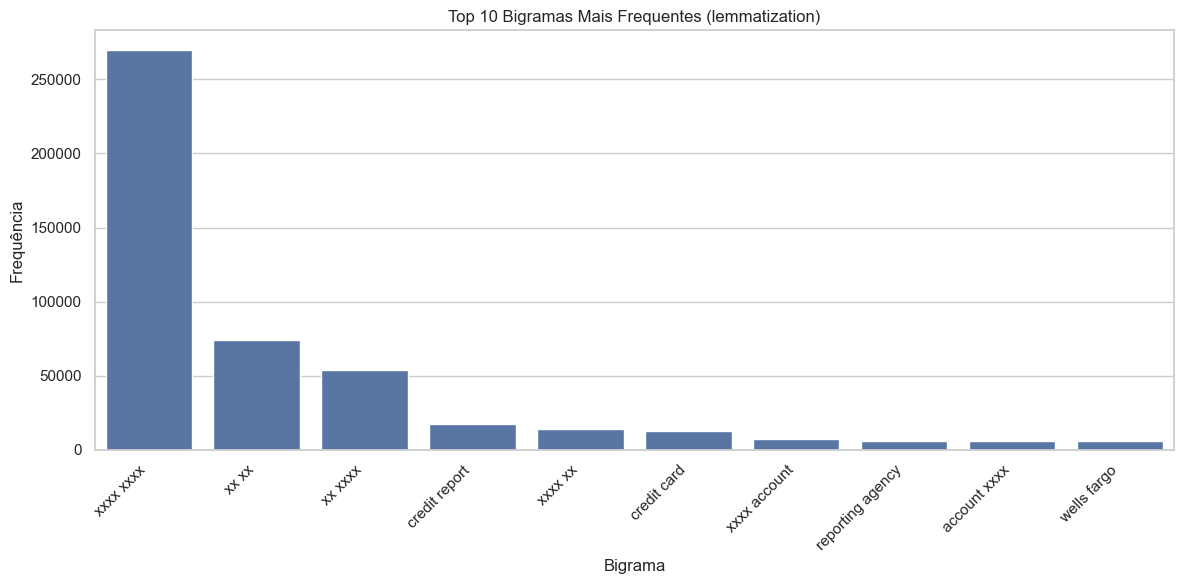

In [18]:
# Executar EDA para cada configuração
eda_results = {}
for config_name, (_, _, column_name) in preprocessing_configs.items():
    custom_stopwords = perform_eda(data_balanced[column_name], config_name)
    eda_results[config_name] = custom_stopwords

# 4. ENCONTRAR O MELHOR N-GRAMA

In [ ]:
# Definir os intervalos de N-gramas a testar
ngram_ranges = [
    (1, 1),  # Apenas unigramas
    (1, 2),  # Unigramas e bigramas
    (1, 3),  # Unigramas, bigramas e trigramas
    (1, 4),  # Unigramas, bigramas, trigramas e quadrigramas
    (2, 2),  # Apenas bigramas
    (2, 3),  # Bigramas e trigramas
    (3, 3),  # Apenas trigramas
]

# Resultados
best_ngrams = {}

# Função para testar N-gramas e encontrar o melhor
def find_best_ngram(config_name, column_name, custom_stopwords):
    print(f"\n#### Testar N-gramas para {config_name} ####")
    ngram_results = []
    
    # Loop para testar diferentes N-gramas
    for ngram_range in ngram_ranges:
        print(f"\nTestar N-gramas com intervalo {ngram_range}...")
        
        # Criar o vetorizador TF-IDF com o intervalo de N-gramas atual
        tfidf = TfidfVectorizer(max_features=4000, ngram_range=ngram_range, stop_words=list(custom_stopwords))
        X = tfidf.fit_transform(data_balanced[column_name])
        y = data_balanced["product_5"]
        
        # Divisão treino/teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Treinar o classificador (Logistic Regression com L2)
        lr_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear')
        lr_l2.fit(X_train, y_train)
        y_pred = lr_l2.predict(X_test)
        
        # Calcular accuracy e F1-score (média macro)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        print(f"accuracy: {acc:.4f}")
        print(f"F1-score (macro): {f1:.4f}")
        
        # Salvar os resultados
        ngram_results.append({
            "N-gram Range": ngram_range,
            "Accuracy": acc,
            "F1-score (macro)": f1
        })
    
    # Exibir os resultados em um DataFrame
    ngram_results_df = pd.DataFrame(ngram_results)
    print(f"\n### Resultados dos Testes de N-gramas para {config_name} ###")
    print(ngram_results_df)
    
    # Identificar o melhor N-grama
    best_ngram = ngram_results_df.loc[ngram_results_df["F1-score (macro)"].idxmax()]
    print(f"\nMelhor N-grama para {config_name}: {best_ngram['N-gram Range']}")
    print(f"accuracy: {best_ngram['Accuracy']:.4f}")
    print(f"F1-score (macro): {best_ngram['F1-score (macro)']:.4f}")
    
    # Salvar os resultados
    ngram_results_df.to_csv(f"ngram_test_results_{config_name}.csv", index=False)
    print(f"\nResultados dos testes de N-gramas salvos em 'ngram_test_results_{config_name}.csv'.")
    
    return best_ngram["N-gram Range"]

## 4.1 Encontrar o Melhor N-grama para Lemmatization

In [20]:
config_name = "lemmatization"
column_name = preprocessing_configs[config_name][2]
custom_stopwords = eda_results[config_name]
best_ngrams[config_name] = find_best_ngram(config_name, column_name, custom_stopwords)


#### Testar N-gramas para lemmatization ####

Testar N-gramas com intervalo (1, 1)...
Acurácia: 0.8530
F1-score (macro): 0.8526

Testar N-gramas com intervalo (1, 2)...
Acurácia: 0.8560
F1-score (macro): 0.8557

Testar N-gramas com intervalo (1, 3)...
Acurácia: 0.8530
F1-score (macro): 0.8527

Testar N-gramas com intervalo (1, 4)...
Acurácia: 0.8518
F1-score (macro): 0.8515

Testar N-gramas com intervalo (2, 2)...
Acurácia: 0.8131
F1-score (macro): 0.8126

Testar N-gramas com intervalo (2, 3)...
Acurácia: 0.8019
F1-score (macro): 0.8014

Testar N-gramas com intervalo (3, 3)...
Acurácia: 0.6709
F1-score (macro): 0.6722

### Resultados dos Testes de N-gramas para lemmatization ###
  N-gram Range  Accuracy  F1-score (macro)
0       (1, 1)    0.8530          0.852571
1       (1, 2)    0.8560          0.855652
2       (1, 3)    0.8530          0.852675
3       (1, 4)    0.8518          0.851505
4       (2, 2)    0.8131          0.812580
5       (2, 3)    0.8019          0.801446
6       (3

## 4.2 Encontrar o Melhor N-grama para Stemming

In [21]:
config_name = "stemming"
column_name = preprocessing_configs[config_name][2]
custom_stopwords = eda_results[config_name]
best_ngrams[config_name] = find_best_ngram(config_name, column_name, custom_stopwords)


#### Testar N-gramas para stemming ####

Testar N-gramas com intervalo (1, 1)...
Acurácia: 0.8524
F1-score (macro): 0.8520

Testar N-gramas com intervalo (1, 2)...
Acurácia: 0.8526
F1-score (macro): 0.8522

Testar N-gramas com intervalo (1, 3)...
Acurácia: 0.8513
F1-score (macro): 0.8510

Testar N-gramas com intervalo (1, 4)...
Acurácia: 0.8504
F1-score (macro): 0.8501

Testar N-gramas com intervalo (2, 2)...
Acurácia: 0.8115
F1-score (macro): 0.8109

Testar N-gramas com intervalo (2, 3)...
Acurácia: 0.8041
F1-score (macro): 0.8035

Testar N-gramas com intervalo (3, 3)...
Acurácia: 0.6695
F1-score (macro): 0.6703

### Resultados dos Testes de N-gramas para stemming ###
  N-gram Range  Accuracy  F1-score (macro)
0       (1, 1)    0.8524          0.851971
1       (1, 2)    0.8526          0.852231
2       (1, 3)    0.8513          0.851018
3       (1, 4)    0.8504          0.850120
4       (2, 2)    0.8115          0.810915
5       (2, 3)    0.8041          0.803510
6       (3, 3)    0.

# 5. CLASSIFICADORES

In [22]:
# Função para treinar e avaliar classificadores
def train_and_evaluate_classifiers(X, y, config_name, vectorizer_type, use_naive_bayes=True):
    print(f"\n##### Classificadores com {vectorizer_type} #####")

    # Divisão treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Naive Bayes (não funciona com embedings porque é só com esparsas)
    if use_naive_bayes:
        print("\nTreinar Naive Bayes...")
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_pred_nb = nb.predict(X_test)
        print(f"Naive Bayes ({vectorizer_type}):\n", classification_report(y_test, y_pred_nb, zero_division=0))
        joblib.dump(nb, f'naive_bayes_{vectorizer_type.lower()}_{config_name.lower()}_50000.joblib')

    # Logistic Regression com L2
    print("\nTreinar Logistic Regression (L2)...")
    lr_l2 = LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear')
    lr_l2.fit(X_train, y_train)
    y_pred_lr_l2 = lr_l2.predict(X_test)
    print(f"Logistic Regression (L2) ({vectorizer_type}):\n", classification_report(y_test, y_pred_lr_l2, zero_division=0))
    print(f"Features ativas (L2): {(lr_l2.coef_ != 0).sum()}")
    joblib.dump(lr_l2, f'logistic_regression_l2_{vectorizer_type.lower()}_{config_name.lower()}_50000.joblib')

    # XGBoost
    print("\nTreinar XGBoost...")
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train_enc)
    y_pred_xgb = xgb.predict(X_test)
    y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)
    print(f"XGBoost ({vectorizer_type}):\n", classification_report(y_test, y_pred_xgb_labels, zero_division=0))
    joblib.dump(xgb, f'xgboost_{vectorizer_type.lower()}_{config_name.lower()}_50000.joblib')

In [23]:
# Função para treinar Word2Vec e vetorizar documento
def train_word2vec_and_vectorize(corpus, config_name):
    print(f"\n#### Treinar Word2Vec para {config_name} ####")
    
    # Tokenizar o corpus
    tokenized_corpus = [doc.split() for doc in corpus]
    
    # Treinar o modelo Word2Vec
    w2v_model = Word2Vec(
        sentences=tokenized_corpus,
        vector_size=100,  # Dimensão dos vetores (baixa para manter o modelo leve)
        window=5,         # Tamanho da janela de contexto
        min_count=5,      # Ignorar palavras com frequência menor que 5
        workers=4,        # Número de threads para treinamento
        sg=1,             # Usar Skip-Gram (1) em vez de CBOW (0)
        epochs=5          # Número de épocas
    )
    
    # Salvar o modelo Word2Vec
    w2v_model.save(f"word2vec_model_{config_name.lower()}_50000.model")
    print(f"Modelo Word2Vec salvo como 'word2vec_model_{config_name.lower()}_50000.model'.")
    
    # Função para vetorizar um documento (média dos vetores das palavras)
    def document_vector(doc):
        words = doc.split()
        word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
        if len(word_vectors) == 0:
            return np.zeros(w2v_model.vector_size)
        return np.mean(word_vectors, axis=0)
    
    # Vetorizar todos os documentos
    X_w2v = np.array([document_vector(doc) for doc in corpus])
    print(f"Tamanho do espaço de features com Word2Vec: {X_w2v.shape[1]} dimensões")
    
    return X_w2v

## 5.1 CLASSIFICADORES COM LEMMATIZATION

In [24]:
# Configuração para Lemmatization
config_name = "lemmatization"
column_name = preprocessing_configs[config_name][2]
custom_stopwords = eda_results[config_name]
best_ngram_range = best_ngrams[config_name]

### Bag-of-Words com CountVectorizer

In [25]:
vectorizer = CountVectorizer(max_features=4000, stop_words=list(custom_stopwords))
X = vectorizer.fit_transform(data_balanced[column_name])
print(f"Tamanho do espaço de features (BoW): {X.shape[1]} features")
train_and_evaluate_classifiers(X, data_balanced["product_5"], config_name, "BoW")

Tamanho do espaço de features (BoW): 4000 features

##### Classificadores com BoW #####

Treinar Naive Bayes...
Naive Bayes (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.90      0.88      1998
      Credit Card Services       0.80      0.79      0.80      1950
          Credit Reporting       0.76      0.79      0.77      2043
           Debt Collection       0.78      0.70      0.74      1993
                     Loans       0.84      0.86      0.85      2016

                  accuracy                           0.81     10000
                 macro avg       0.81      0.81      0.81     10000
              weighted avg       0.81      0.81      0.81     10000


Treinar Logistic Regression (L2)...
Logistic Regression (L2) (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.87      0.89      0.88      1998
      Credit Card Services       0.82      0.8

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.90      0.90      1998
      Credit Card Services       0.84      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.80      0.81      1993
                     Loans       0.87      0.88      0.88      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama

In [26]:
tfidf_ngrams = TfidfVectorizer(max_features=4000, ngram_range=best_ngram_range, stop_words=list(custom_stopwords))
X_tfidf_ngrams = tfidf_ngrams.fit_transform(data_balanced[column_name])
print(f"Tamanho do espaço de features com N-grams (TF-IDF): {X_tfidf_ngrams.shape[1]}")
joblib.dump(tfidf_ngrams, f'tfidf_ngrams_vectorizer_{config_name.lower()}_50000.joblib')
train_and_evaluate_classifiers(X_tfidf_ngrams, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_{best_ngram_range}")

Tamanho do espaço de features com N-grams (TF-IDF): 4000

##### Classificadores com TFIDF_Ngrams_(1, 2) #####

Treinar Naive Bayes...
Naive Bayes (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.93      0.89      1998
      Credit Card Services       0.82      0.78      0.80      1950
          Credit Reporting       0.78      0.80      0.79      2043
           Debt Collection       0.81      0.73      0.77      1993
                     Loans       0.85      0.87      0.86      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000


Treinar Logistic Regression (L2)...
Logistic Regression (L2) (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.92      0.90   

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.83      0.82      2043
           Debt Collection       0.83      0.80      0.81      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama e Normalização

In [27]:
scaler = StandardScaler(with_mean=False)
X_tfidf_ngrams_scaled = scaler.fit_transform(X_tfidf_ngrams)
train_and_evaluate_classifiers(X_tfidf_ngrams_scaled, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_Scaled_{best_ngram_range}")


##### Classificadores com TFIDF_Ngrams_Scaled_(1, 2) #####

Treinar Naive Bayes...
Naive Bayes (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.91      0.87      1998
      Credit Card Services       0.79      0.78      0.78      1950
          Credit Reporting       0.79      0.76      0.78      2043
           Debt Collection       0.78      0.72      0.75      1993
                     Loans       0.83      0.86      0.84      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000


Treinar Logistic Regression (L2)...
Logistic Regression (L2) (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.83      0.83      1998
      Credit Card Services  

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.83      0.82      2043
           Debt Collection       0.83      0.80      0.81      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### Embedings Word2Vec (representação densa)

In [28]:
X_w2v = train_word2vec_and_vectorize(data_balanced[column_name], config_name)
train_and_evaluate_classifiers(X_w2v, data_balanced["product_5"], config_name, "Word2Vec", use_naive_bayes=False)


#### Treinar Word2Vec para lemmatization ####
Modelo Word2Vec salvo como 'word2vec_model_lemmatization_50000.model'.
Tamanho do espaço de features com Word2Vec: 100 dimensões

##### Classificadores com Word2Vec #####

Treinar Logistic Regression (L2)...
Logistic Regression (L2) (Word2Vec):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.87      0.85      1998
      Credit Card Services       0.76      0.76      0.76      1950
          Credit Reporting       0.75      0.79      0.77      2043
           Debt Collection       0.80      0.71      0.75      1993
                     Loans       0.83      0.84      0.84      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000

Features ativas (L2): 500

Treinar XGBoost...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Word2Vec):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.85      0.87      0.86      1998
      Credit Card Services       0.78      0.77      0.77      1950
          Credit Reporting       0.81      0.83      0.82      2043
           Debt Collection       0.80      0.77      0.79      1993
                     Loans       0.83      0.84      0.84      2016

                  accuracy                           0.81     10000
                 macro avg       0.81      0.81      0.81     10000
              weighted avg       0.81      0.81      0.81     10000



## 5.2 CLASSIFICADORES COM STEMMING

In [29]:
# Configuração para Stemming
config_name = "stemming"
column_name = preprocessing_configs[config_name][2]
custom_stopwords = eda_results[config_name]
best_ngram_range = best_ngrams[config_name]

### Bag-of-Words com CountVectorizer

In [30]:
vectorizer = CountVectorizer(max_features=4000, stop_words=list(custom_stopwords))
X = vectorizer.fit_transform(data_balanced[column_name])
print(f"Tamanho do espaço de features (BoW): {X.shape[1]} features")
train_and_evaluate_classifiers(X, data_balanced["product_5"], config_name, "BoW")

Tamanho do espaço de features (BoW): 4000 features

##### Classificadores com BoW #####

Treinar Naive Bayes...
Naive Bayes (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.85      0.90      0.88      1998
      Credit Card Services       0.79      0.77      0.78      1950
          Credit Reporting       0.74      0.78      0.76      2043
           Debt Collection       0.78      0.69      0.73      1993
                     Loans       0.84      0.86      0.85      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000


Treinar Logistic Regression (L2)...
Logistic Regression (L2) (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.88      0.87      1998
      Credit Card Services       0.81      0.8

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.84      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.80      0.82      1993
                     Loans       0.87      0.88      0.88      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama

In [31]:
tfidf_ngrams = TfidfVectorizer(max_features=4000, ngram_range=best_ngram_range, stop_words=list(custom_stopwords))
X_tfidf_ngrams = tfidf_ngrams.fit_transform(data_balanced[column_name])
print(f"Tamanho do espaço de features com N-grams (TF-IDF): {X_tfidf_ngrams.shape[1]}")
joblib.dump(tfidf_ngrams, f'tfidf_ngrams_vectorizer_{config_name.lower()}_50000.joblib')
train_and_evaluate_classifiers(X_tfidf_ngrams, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_{best_ngram_range}")

Tamanho do espaço de features com N-grams (TF-IDF): 4000

##### Classificadores com TFIDF_Ngrams_(1, 2) #####

Treinar Naive Bayes...
Naive Bayes (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.93      0.89      1998
      Credit Card Services       0.82      0.78      0.80      1950
          Credit Reporting       0.78      0.79      0.79      2043
           Debt Collection       0.81      0.73      0.77      1993
                     Loans       0.84      0.87      0.85      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000


Treinar Logistic Regression (L2)...
Logistic Regression (L2) (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.92      0.90   

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:21:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.90      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.81      0.82      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama e Normalização

In [32]:
scaler = StandardScaler(with_mean=False)
X_tfidf_ngrams_scaled = scaler.fit_transform(X_tfidf_ngrams)
train_and_evaluate_classifiers(X_tfidf_ngrams_scaled, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_Scaled_{best_ngram_range}")


##### Classificadores com TFIDF_Ngrams_Scaled_(1, 2) #####

Treinar Naive Bayes...
Naive Bayes (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.90      0.86      1998
      Credit Card Services       0.79      0.77      0.78      1950
          Credit Reporting       0.79      0.75      0.77      2043
           Debt Collection       0.77      0.73      0.75      1993
                     Loans       0.82      0.86      0.84      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000


Treinar Logistic Regression (L2)...
Logistic Regression (L2) (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.83      0.83      0.83      1998
      Credit Card Services  

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:24:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.90      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.81      0.82      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### Embedings Word2Vec

In [33]:
X_w2v = train_word2vec_and_vectorize(data_balanced[column_name], config_name)
train_and_evaluate_classifiers(X_w2v, data_balanced["product_5"], config_name, "Word2Vec", use_naive_bayes=False)


#### Treinar Word2Vec para stemming ####
Modelo Word2Vec salvo como 'word2vec_model_stemming_50000.model'.
Tamanho do espaço de features com Word2Vec: 100 dimensões

##### Classificadores com Word2Vec #####

Treinar Logistic Regression (L2)...
Logistic Regression (L2) (Word2Vec):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.82      0.87      0.84      1998
      Credit Card Services       0.76      0.75      0.75      1950
          Credit Reporting       0.75      0.79      0.77      2043
           Debt Collection       0.81      0.72      0.76      1993
                     Loans       0.83      0.84      0.83      2016

                  accuracy                           0.79     10000
                 macro avg       0.79      0.79      0.79     10000
              weighted avg       0.79      0.79      0.79     10000

Features ativas (L2): 500

Treinar XGBoost...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (Word2Vec):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.85      0.86      0.86      1998
      Credit Card Services       0.78      0.77      0.78      1950
          Credit Reporting       0.79      0.84      0.81      2043
           Debt Collection       0.82      0.77      0.79      1993
                     Loans       0.85      0.84      0.84      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000



In [34]:
# Salvar dataset processado
data_balanced.to_csv("consumer_complaints_50000_processed.csv", index=False)
print("\nDataset processado salvo como 'consumer_complaints_50000_processed.csv'.")


Dataset processado salvo como 'consumer_complaints_50000_processed.csv'.
